Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 657us/step - loss: 0.0720 
Epoch 2/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 574us/step - loss: 0.0341
Epoch 3/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 0.0337
Epoch 4/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 718us/step - loss: 0.0294
Epoch 5/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 0.0295
Epoch 6/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - loss: 0.0281
Epoch 7/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 775us/step - loss: 0.0289
Epoch 8/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 763us/step - loss: 0.0293
Epoch 9/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 817us/step - loss: 0.0295
Epoch 10/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - loss: 0.0271
Epoch 11/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 0.0289
Epoch 12/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 654us/step - loss: 0.0281
Epoch 13/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 655us/step - loss: 0.0273
Epoch 14/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 668us/step - loss: 0.0284
Epoch 15/100
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step 

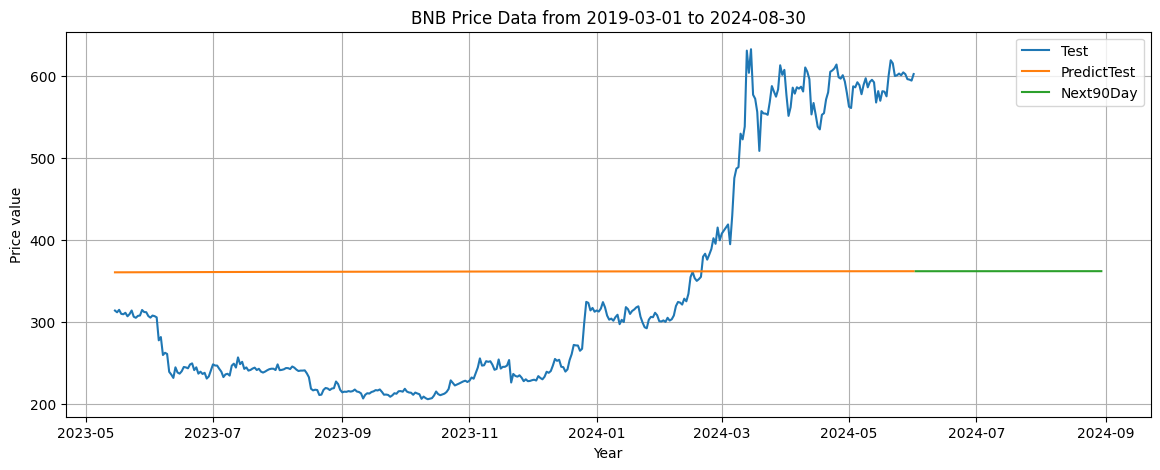

In [1]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from keras.models import Sequential
from keras.layers import Dense, LSTM

# Load data
df = pd.read_csv(r'/Users/khoanguyen/Downloads/BNB-Historical-Data.csv', on_bad_lines='skip', low_memory=False)
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)
# Select the Close column as the dependent variable
df_Price = df[['Price']]
df_Price = df_Price.reset_index(drop=True)

# Min-max normalization
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(np.array(df_Price))

# Split data into train and test sets
train_size = int(0.8 * len(data_scaled))
test_size = int(0.2 * len(data_scaled))

train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Preparing training data
x_train = np.arange(train_size).reshape(-1, 1)
y_train = train_data.reshape(-1)

# Reshape data for LSTM input [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
model.fit(x_train, y_train, epochs=100, batch_size=32)

# Preparing testing data
x_test = np.array(range(train_size, len(data_scaled))).reshape(-1, 1)
y_test = np.array(test_data).reshape(-1)

# Reshape data for LSTM input [samples, time steps, features]
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

# Predict the closing prices for the test data
y_pred = model.predict(x_test)
y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))

# Evaluate the accuracy of the test data
y_test = scaler.inverse_transform(np.array([y_test]).reshape(-1, 1))
test_mape = mean_absolute_percentage_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)


print(f"MAPE on Test dataset: {test_mape}")
print(f"RMSE on Test dataset: {test_rmse}")
print(f"MSE on Test dataset: {test_mse}")


# The process of creating index to predict the next 90 days
last_index = df_Price.index[-1]

# Create an array of 90 consecutive integers starting from last_index
x_next_90_days = np.array(range(last_index + 1, last_index + 91)).reshape(-1, 1)

# Reshape data for LSTM input [samples, time steps, features]
x_next_90_days = np.reshape(x_next_90_days, (x_next_90_days.shape[0], 1, x_next_90_days.shape[1]))

# Predict the closing prices for the next 90 days
y_next_90_days = model.predict(x_next_90_days)
y_next_90_days = scaler.inverse_transform(y_next_90_days.reshape(-1, 1))

# Print the predicted closing prices for the next 90 days
print('Predicted BNB prices for the next 90 days:')
print(y_next_90_days.flatten())

# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 90 days
index_next_90_days = pd.date_range(start=next_date, periods=90).tolist()

# Drawing
plt.figure(figsize=(14, 5))
plt.plot(df.index[train_size:], y_test)
plt.plot(df.index[train_size:], y_pred)
plt.plot(index_next_90_days, y_next_90_days)
plt.legend(['Test', 'PredictTest', 'Next90Day'])
plt.grid()
plt.title(f"BNB Price Data from {df.index[0].strftime('%Y-%m-%d')} to {index_next_90_days[-1].strftime('%Y-%m-%d')}")
plt.xlabel("Year")
plt.ylabel("Price value")
plt.show()